## Homework 2: Glow

Напомним, что нормализующие потоки — это класс генеративных моделей, которые строят сложную, но при этом обратимую функцию $\boldsymbol{f}_{\boldsymbol{\theta}}$, отображающую некоторое простое распределение в сложное распределения наших данных. Обучая эту функцию, мы сможем генерировать новые данные и оценивать их плотность $p_{\boldsymbol{\theta}}(\mathbf{x})$.

Это становится возможным благодаря теореме о замене переменных, которая лежит в основе нормализующих потоков. Она позволяет связать плотность $p_{\boldsymbol{\theta}}(\mathbf{x})$ с плотностью базового распределения $p(\mathbf{z}$) через обратимую функцию $\boldsymbol{f}_{\boldsymbol{\theta}}$
и её якобиан:

$$p_{\boldsymbol{\theta}}(\mathbf{x}) = p(\boldsymbol{f}_{\boldsymbol{\theta}}(\mathbf{x})) \bigg| \det\left(\frac{\partial\boldsymbol{f_{\boldsymbol{\theta}}}​}{\partial \mathbf{x}} \right) \bigg|$$

Обычно функция $\boldsymbol{f}_{\boldsymbol{\theta}}$ — это не простое преобразование, а сложная композиция нескольких обратимых функций:

$$\boldsymbol{f}_{\boldsymbol{\theta}} = \boldsymbol{f}_{K, \boldsymbol{\theta}}\circ \dots\circ \boldsymbol{f}_{1,\boldsymbol{\theta}}$$
​
Поскольку детерминант якобиана всей композиции равен произведению детерминантов якобианов каждого преобразования, мы можем переписать формулу в следующем виде:

$$p_{\boldsymbol{\theta}}(\mathbf{x}) = p(\mathbf{z}_K) \left| \prod_{k=1}^K \det\left(\frac{\partial \boldsymbol{f}_{k,\boldsymbol{\theta}}}{\partial \mathbf{z}_{k-1}} \right) \right|$$

<center><img src="images/flow.png" width=700></center>

На семинаре мы познакомились с архитектурой **RealNVP** и увидели две главные особенности модели — **Affine Coupling Layers** и **Multi-Scale архитектуру**.

Однако, как и в любой работе, в **RealNVP** оставались моменты, которые можно было улучшить. Именно этим и занялись исследователи из `OpenAI` и предложили модель [Glow](https://arxiv.org/pdf/1807.03039). Она берет лучшее от RealNVP и улучшает слабые места:

- Вместо фиксированной перестановки использует `обратимую 1x1 свертку`, которая позволяет модели самой находить оптимальный способ перемешивания каналов.

- Вместо стандартного `BatchNorm`, который плохо работает с маленькими батчами, использует `ActNorm`.

### Задание

Вам предстоит реализовать модель `Glow` и обучить модель на датасете `CelebA` для решения задачи генерации лиц.

За выполнение домашнего задания можно получить до **10 баллов**. Для части заданий мы написали для вас скелет. Заполните в них пропуски, выделенные с помощью `...`.

In [1]:
import math
import os
from typing import List, Optional, Tuple
import zipfile

from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import requests
import torch
import torch.distributions as D
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm

### Задание 1: Dataset (0.5 балла)

Для обучения нашей модели мы будем использовать датасет `CelebA`, который содержит более $200$ тыс. изображений лиц знаменитостей. Поскольку стандартные средства torchvision для его загрузки часто нестабильны, мы скачаем архив с изображениями напрямую и напишем датасет самостоятельно.

**Ваша задача**:

- Скачать и распаковать архив с датасетом

- Создать преобразования для всех изображений:
    - обрезать до квадрата по центру размером $148\times148$ (`CenterCrop`),
    - измененить размера до $64\times64$ (`Resize`)
    - преобразовать в тензор (`ToTensor`).

- Реализовать и создать класс CelebADataset.

- Разделить созданный датасет на обучающую и валидационную выборки в соотношении $90\% / 10\%$

- Создать DataLoader'ы для каждой выборки.

In [2]:
def download_and_unzip(url, save_path, extract_path, chunk_size=128):
    if os.path.exists(extract_path):
        print(f"Directory '{extract_path}' already exists. Skipping download.")
        return

    print(f"Downloading archive from {url}...")
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in tqdm(r.iter_content(chunk_size=chunk_size)):
            fd.write(chunk)
    print("Download complete.")

    print(f"Unzipping archive '{save_path}'...")
    with zipfile.ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(extract_path))
    print("Unzipping complete.")
    os.remove(save_path)
    print(f"Archive '{save_path}' deleted.")

DATASET_URL = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"
ZIP_PATH = "celeba.zip"
DATA_ROOT = "./data/celeba"
IMAGE_DIR = os.path.join(DATA_ROOT, "img_align_celeba")

download_and_unzip(DATASET_URL, ZIP_PATH, IMAGE_DIR)

Directory '/data/celeba\img_align_celeba' already exists. Skipping download.


In [3]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)

        # Конвертируем в RGB если нужно
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [4]:
# Преобразования для изображений
transform = transforms.Compose([
    transforms.CenterCrop(148),      # Обрезаем до квадрата 148x148 по центру
    transforms.Resize(64),           # Изменяем размер до 64x64
    transforms.ToTensor()            # Преобразуем в тензор [0, 1]
])

In [5]:
generator = torch.Generator().manual_seed(42)   # for train_test split

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Your code here

# Создаем полный датасет
full_dataset = CelebADataset(root_dir=IMAGE_DIR, transform=transform)

# Разделяем на train/val в соотношении 90%/10%
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Параметры загрузки
batch_size = 16
num_workers = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
to_use_pin_memory = (device.type == 'cuda')

# Создаём DataLoader'ы
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

Давайте взглянем на наши данные.

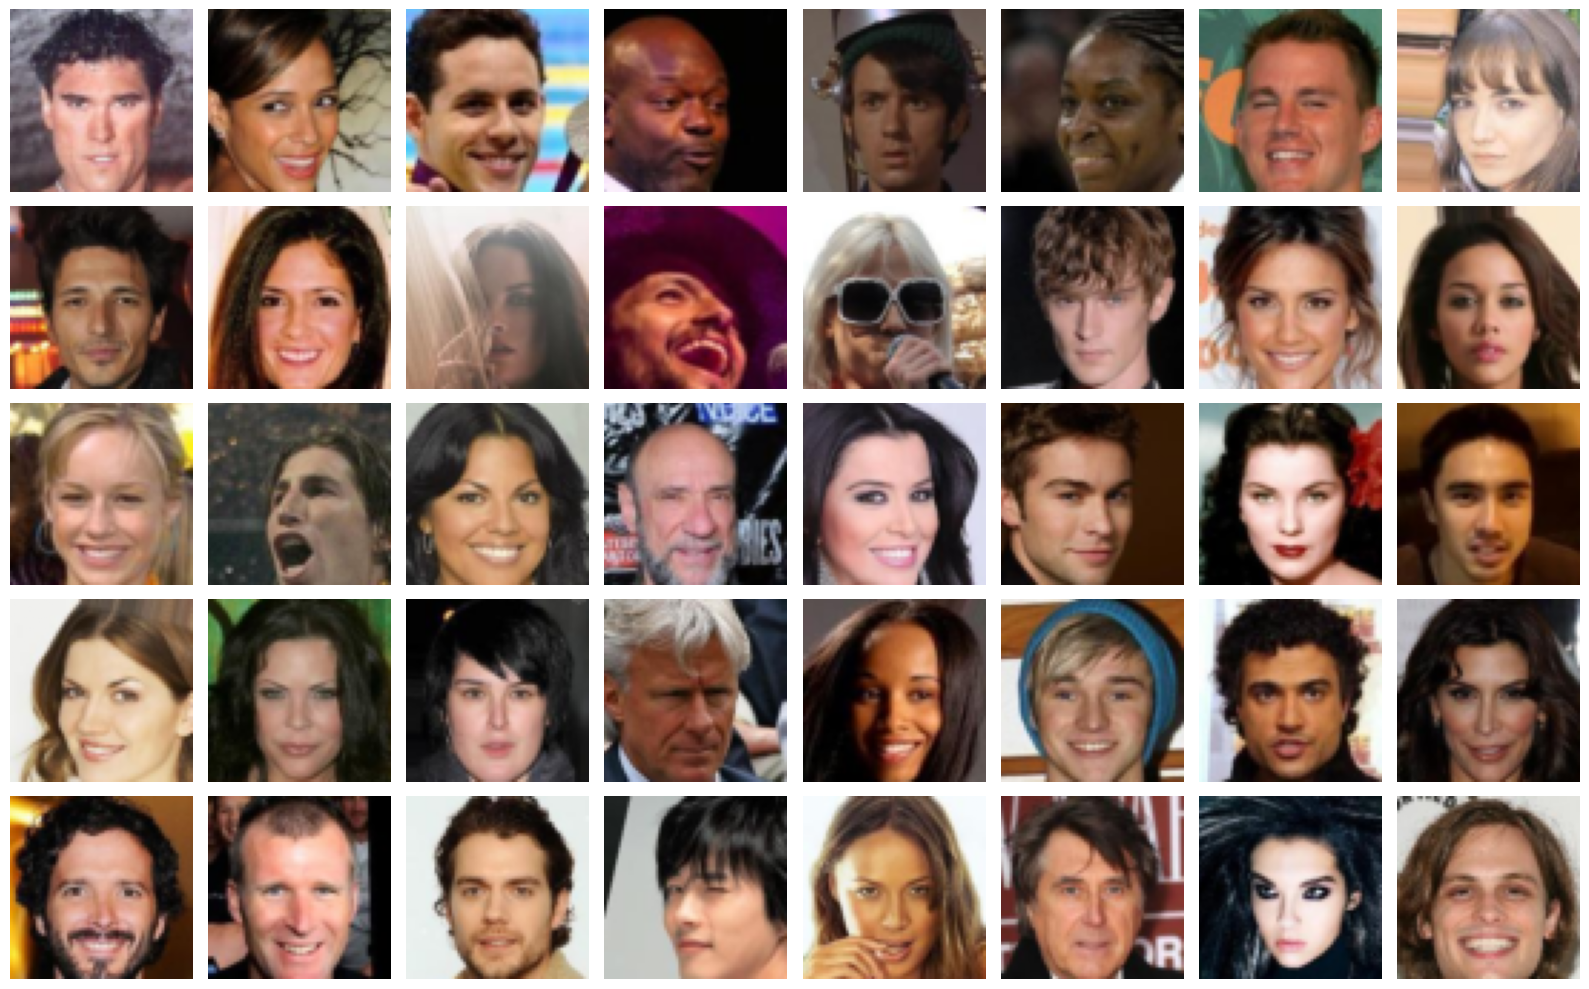

In [6]:
indices = torch.randperm(len(train_dataset))[:40]

fig, axes = plt.subplots(5, 8, figsize=(16, 10))

for i, ax in enumerate(axes.flat):
    image = train_dataset[indices[i]]

    image = image.permute(1, 2, 0).cpu().numpy()

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Задание 2: ActNorm (1 балл)

Одним из важных нововведений модели Glow является слой `ActNorm`. Как и `BatchNorm`, он выполняет аффинное преобразование $y = s\cdot x + b$ для каждого канала, чтобы стабилизировать и ускорить обучение. Однако параметры масштаба (`scale`) и сдвига (`bias`) в `ActNorm` не зависят от текущего батча, а являются обучаемыми параметрами модели.

При этом есть небольшая особенность в их инициализации, которая **зависит от данных**:

- При первом проходе данных через модель (на самом первом батче), параметры `scale` и `bias` вычисляются таким образом, чтобы выходные активации для каждого канала имели нулевое среднее и единичную дисперсию.

- После такой инициализации, они становятся обычными параметрами и обновляются с помощью градиентного спуска, как и все остальные веса сети.

Такой подход делает `ActNorm` независимым от размера батча, что важно для обучения на больших изображениях, где размер батча часто приходится делать очень маленьким.

Как и любой слой в нормализующем потоке, `ActNorm` должен быть обратимым и иметь легко вычисляемый детерминант якобиана. Для преобразования $\mathbf{z}=\mathbf{s}\odot\mathbf{x}+\mathbf{b}$, логарифм детерминанта имеет вид:

$$\log|\det(\mathbf{J}^{Actnorm})| = h \cdot w \cdot \sum_{c=1}^C(\log|s_c|)$$

​
Здесь $s_c$ — это параметр масштаба для $c$-го канала, $h\cdot w$ — количество пикселей в изображении.

Вам необходимо реализовать класс `ActNorm`. В конструкторе уже определены параметры `scale`, `bias` и флаг `initialized`.

Ваша задача — заполнить пропуски в методах `forward` и `inverse`.
​

In [7]:
class ActNorm(nn.Module):
    def __init__(self, num_channels: int):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1))

        # Register a buffer to track whether the layer has been initialized.
        self.register_buffer("initialized", torch.tensor(False, dtype=torch.bool))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, num_channels, height, width = x.shape
        # Data-dependent initialization: this block runs only once, on the first forward pass.
        if not self.initialized:

            # Calculate mean and std for each channel
            mean = x.mean(dim=(0, 2, 3), keepdim=True)  # [1, C, 1, 1]
            std = x.std(dim=(0, 2, 3), keepdim=True)    # [1, C, 1, 1]

            # Initialize scale and bias using the calculated statistics.
            # Чтоб mean=0, std=1, делаем b = -mean/std и s = 1/std.
            self.scale.data = 1.0 / std
            self.bias.data = -mean * self.scale.data

            # Mark the layer as initialized
            self.initialized.data = torch.tensor(True, dtype=torch.bool)

        # Apply the forward affine transformation
        z = self.scale * x + self.bias

        # Calculate the log-determinant of the Jacobian for the forward pass.
        # log|det(J)| = h * w * sum_c(log|s_c|)
        logdet = height * width * torch.sum(torch.log(torch.abs(self.scale)))

        return z, logdet

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        # Apply the inverse transformation.
        x = (z - self.bias) / self.scale

        return x

### Задание 3: Invertible 1x1 Convolution (1.5 балла)

В **слоях связи** (**Affine Coupling Layers**) за один шаг преобразование затрагивает только половину каналов. Чтобы модель была мощной, информация между этими шагами должна "перемешиваться", позволяя всем каналам влиять друг на друга. В RealNVP для этого использовалась фиксированная перестановка каналов. Это работало, но было неоптимально, так как модель не могла "научиться" лучшему способу перемешивания.

В **Glow** для этого предложили использовать **обратимую свертку $1\times 1$** (`Invertible 1x1 Convolution`). С точки зрения математики, свертка $1\times1$ с матрицей весов $\mathbf{W}$ размера $C\times C$ эквивалентна умножению вектора каналов C на эту матрицу для каждого пикселя в изображении. Таким образом, эта свертка и есть наше обучаемое перемешивание.

Основная сложность здесь — вычислить детерминант якобиана. Для свертки $1\times1$ якобиан — это и есть матрица весов $\mathbf{W}$. Прямое вычисление $\det(\mathbf{W})$ имеет сложность $\mathcal{O}(C^3)$. Чтобы избежать этого, авторы **Glow** параметризуют матрицу $\mathbf{W}$ через ее `LU-разложение`:

$$\mathbf{W}=\mathbf{P}\mathbf{L}(\mathbf{U}+diag(\mathbf{s}))$$

где $\mathbf{P}$ — матрица перестановки, $\mathbf{L}$ — нижнетреугольная матрица с единицами на диагонали, $\mathbf{U}$ — верхнетреугольная матрица с нулями на диагонали, $diag(\mathbf{s})$ - диагональная матрица, у которой на диагонали стоят элементы вектора $\mathbf{s}$, а в остальных местах — нули.

В результате мы получим, что

$$\log|\det(\mathbf{J}^{Conv1x1 ​ })| = h \cdot w \cdot \log |\det (\mathbf{W})|$$

$$\log|\det(\mathbf{W})| = \log|\det(\mathbf{P})\cdot\det(\mathbf{L})\cdot\det(\mathbf{U}+diag(\mathbf{s}))| = $$
$$= \log|±1 \cdot 1 \cdot \prod_{c=1}^{C} s_c| = \sum_{c=1}^C \log|s_c|,
$$

где $s_c$ — диагональные элементы матрицы $\mathbf{U}$.  
Обратная матрица для обратного преобразования:  
$$
\mathbf{W}^{-1} = (\mathbf{U}+diag(\mathbf{s}))^{-1}\cdot\mathbf{L}^{-1}\cdot\mathbf{P}^{T}
$$

В этом задании вам предстоит реализовать слой `Invertible1x1Conv`.

Для выполнения задания рекомендуем ознакомиться с [`LU-разложением`](https://docs.pytorch.org/docs/stable/generated/torch.linalg.lu.html) в `Pytorch`.

In [8]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels: int):
        super().__init__()
        self.num_channels = num_channels
        # Initialize with a random orthogonal matrix
        w_init = torch.linalg.qr(torch.randn(num_channels, num_channels))[0]

        # Perform LU-decomposition
        P, L, U = torch.linalg.lu(w_init)

        # Extract diagonal elements 's' from U
        s = U.diag()
        sign_s = torch.sign(s)

        # Remove diagonal from U and set diagonal to ones for L
        U_no_diag = U - torch.diag(U.diag())
        L_no_diag = L - torch.diag(torch.ones(num_channels))

        # Register P (permutation), sign_s, L and U masks as non-trainable buffers
        self.register_buffer('P', P)
        self.register_buffer('sign_s', sign_s)
        self.register_buffer('L_mask', torch.tril(torch.ones(num_channels, num_channels), -1))
        self.register_buffer('U_mask', torch.triu(torch.ones(num_channels, num_channels), 1))

        # Define L, U (without diagonal) and log_s as learnable parameters
        self.l = nn.Parameter(L_no_diag)
        self.u = nn.Parameter(U_no_diag)
        self.log_s = nn.Parameter(torch.log(torch.abs(s)))

    def _calculate_weight(self, inverse: bool) -> torch.Tensor:

        # Reconstruct L from the learnable part self.l and an identity matrix
        l = torch.diag(torch.ones(self.num_channels, device=self.l.device)) + self.l * self.L_mask

        # Reconstruct U
        u = torch.diag(self.sign_s * torch.exp(self.log_s)) + self.u * self.U_mask

        if inverse:
            # W^{-1} = (PLU)^{-1} = U^{-1}L^{-1}P^T
            # torch.linalg.solve(L, P.t()) = L⁻¹ × Pᵀ
            # torch.linalg.solve(U, L⁻¹ × Pᵀ) = U⁻¹ × L⁻¹ × Pᵀ
            w_inv = torch.linalg.solve(u, torch.linalg.solve(l, self.P.t()))
            return w_inv
        else:
            w = self.P @ l @ u
            return w

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, num_channels, height, width = x.shape

        # Get the weight matrix
        weight = self._calculate_weight(inverse=False)

        # Apply the 1x1 convolution
        # вход: ij - матрица W[i,j], bjhw - изображение[b, j, h, w]
        # получаем bihw - новое изображение[b, i, h, w]
        # Для каждого пикселя (h,w) в каждом батче (b):
        # берём вектор из 3 каналов (j) и умножаем на матрицу W[i,j],
        # чтобы получить новый вектор из 3 каналов (i) Другими словами эта функция делает:
        # "применить матрицу к каналам каждого пикселя, сохранить все остальные размерности"
        z = torch.einsum('ij,bjhw->bihw', weight, x)

        # Calculate the log-determinant: log|det(W)| = sum(log|s|)
        logdet = height * width * torch.sum(self.log_s)

        return z, logdet

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        # Get the inverse weight matrix
        weight_inv = self._calculate_weight(inverse=True)

        # Apply the inverse 1x1 convolution
        x = torch.einsum('ij,bjhw->bihw', weight_inv, z)

        return x

### Задание 4: Affine Coupling Layers (1 балл)

Основой как RealNVP, так и Glow, является **афинный слой связи** (**Affine Coupling Layer**). Его дизайн был настолько удачен, что в Glow он остался без изменений.

Напомним, что в таких слоях входной вектор делился на две части $\mathbf{x}_{1:d}$ и $\mathbf{x}_{d+1:D}$, а латентный вектор $\mathbf{z}$ получался следующим образом:

$$\begin{cases} \mathbf{z}_{1:d} &= \mathbf{x}_{1:d} \\ \mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D}\odot e^{s(\mathbf{x}_{1:d})} + t(\mathbf{x}_{1:d}) \end{cases}$$  

Благодаря такому преобразованию, искомый определитель якобиана вычислялся очень просто:

$$\det(\mathbf{J}) = \prod_{j=1}^{D-d}e^{s(\mathbf{x}_{1:d})_j} = e^{\sum_{j=1}^{D-d} s(\mathbf{x}_{1:d})_j}$$

$$\log|\det(\mathbf{J}^{Coupling})| = \sum_{j=1}^{D-d} s(\mathbf{x}_{1:d})_j$$

В этом задании вам предстоит реализовать слой `AffineCouplingLayer`. В конструкторе уже определена нейросеть `self.net`, которая будет вычислять параметры `s` и `t`.

Используем сигмоиду вместо экспоненты  
$$\begin{cases} \mathbf{z}_{1:d} &= \mathbf{x}_{1:d} \\ \mathbf{z}_{d+1:D} &= \mathbf{x}_{d+1:D}\odot \sigma(s(\mathbf{x}_{1:d}) + 2) + t(\mathbf{x}_{1:d}) \end{cases}$$
Так ограничим масштаб диапазоном от 0 до 1, чтоб не было никаких взрывов.
$$\det(\mathbf{J}) = \prod_{j=1}^{D-d}\sigma(s(\mathbf{x}_{1:d})_j + 2)$$

$$\log|\det(\mathbf{J}^{Coupling})| = \sum_{j=1}^{D-d} log(\sigma(s(\mathbf{x}_{1:d})_j + 2))$$

In [9]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, num_channels: int, hidden_channels: int = 512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_channels // 2, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, num_channels, kernel_size=3, padding=1)
        )
        # We initialize the last layer with zeros, so the whole coupling layer starts
        # as a near-identity function (z ≈ x), which ensures a stable start to training.
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Split the input tensor into two halves along the channel dimension
        # [batch, num_channels, H, W] -> 2 x [batch, num_channels//2, H, W]
        x_a, x_b = x.chunk(2, dim=1)

        # Pass one half through the network to get the parameters for the other half and get log_s and t
        # в net [batch, num_channels//2, H, W] -> [batch, num_channels, H, W]
        # потом разделяем [batch, num_channels, H, W] -> 2 x [batch, num_channels//2, H, W]
        s, t = self.net(x_a).chunk(2, dim=1)

        # Get s [batch, num_channels//2, H, W]
        # Get scale using sigmoid: scale = sigmoid(s + 2)
        # This gives scale in range (0, 1)
        # scale, z_b взято как в https://github.com/openai/glow/blob/master/model.py
        scale = torch.sigmoid(s + 2.0)

        # Apply the affine transformation to the other half: z_b = (x_b + t) * scale
        # [batch, num_channels//2, H, W]
        z_b = (x_b + t) * scale

        # Concatenate the transformed half and the unchanged half
        # 2 x [batch, num_channels//2, H, W] -> [batch, num_channels, H, W]
        z = torch.cat([x_a, z_b], dim=1)

        # Calculate the log-determinant: log|det(J)| = sum(log(scale))
        # Since scale = sigmoid(s + 2), we compute log(scale) directly
        logdet = torch.sum(torch.log(scale), dim=[1, 2, 3])  # [batch]
        return z, logdet

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        # Split the input tensor z into two halves
        # [batch, num_channels, H, W] -> 2 x [batch, num_channels//2, H, W]
        z_a, z_b = z.chunk(2, dim=1)

        # Pass the unchanged half to get the parameters
        # в net [batch, num_channels//2, H, W] -> [batch, num_channels, H, W]
        # потом разделяем [batch, num_channels, H, W] -> 2 x [batch, num_channels//2, H, W]
        s, t = self.net(z_a).chunk(2, dim=1)
        scale = torch.sigmoid(s + 2.0)
        # Apply the inverse affine transformation
        x_b = z_b / scale - t
        # Concatenate the result with the unchanged half
        x = torch.cat([z_a, x_b], dim=1)

        return x

### Задание 5: Squeeze (0.5 балла)

Операция **сжатия** (**Squeeze**) является важной особенностью **Multi-Scale архитектуры**, унаследованной от `RealNVP`. Её задача — изменить форму тензора, преобразуя пространственные размерности в канальные.

В этом задании вам нужно реализовать прямое и обратное преобразование для слоя `Squeeze`.

In [10]:
class Squeeze(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # [batch, num_channels, height, width] -> [batch, num_channels*4, height//2, width//2]

        batch_size, num_channels, height, width = x.shape

        # Reshape the tensor to factor out 2x2 blocks from spatial dimensions
        assert height % 2 == 0 and width % 2 == 0, "height and width must be divisible by 2"

        x =  x.view(batch_size, num_channels, height // 2, 2, width // 2, 2)

        # Permute the dimensions to bring the 2x2 factors next to the channel dimension
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()  # [batch, num_channels, 2, 2, height//2, width//2]

        # Reshape again to merge the new dimensions with the channel dimension.
        x = x.reshape(batch_size, num_channels * 4, height // 2, width // 2)

        return x

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        # [batch, num_channels* 4, height, width] -> [batch, num_channels, height*2, width*2]

        batch_size, num_channels_4, height, width = z.shape
        assert num_channels_4 % 4 == 0, "num_channels must be divisible by 4"
        num_channels = num_channels_4 // 4

        # Reshape to factor out the channel dimension back into 2x2 blocks.
        z = z.view(batch_size, num_channels, 2, 2, height, width)

        # Permute the dimensions to move the 2x2 blocks back to the spatial dimensions.
        z = z.permute(0, 1, 4, 2, 5, 3).contiguous()  # [batch, num_channels, height, 2, width, 2]

        # Reshape again to get the final output.
        z = z.reshape(batch_size, num_channels, height * 2, width * 2)
        return z

### Задание 6: Split and GaussianPrior (1 балл)

**Multi-Scale архитектура** `Glow/RealNVP` работает по принципу **factoring out**. На каждом уровне (кроме последнего) мы **отщепляем** половину каналов, превращая их в латентные переменные $\mathbf{z}$, а оставшуюся часть отправляем снова в модель. За это отвечают слои `Split` и `GaussianPrior`.

- Задача `Split`разделить входной тензор $\mathbf{x}$ на две половины, $\mathbf{x}_1$ и $\mathbf{x}_2$, затем передать их в `GaussianPrior` для обработки и собирать результаты.

- `GaussianPrior` принимает $\mathbf{x}_1$ как условие и $\mathbf{x}_2$ как таргет. С помощью нейросети он предсказывает параметры `mean` и `log_std` нормального распределения для $\mathbf{x}_2$, основываясь на $\mathbf{x}_1$. Затем он использует эти параметры, чтобы выполнить преобразование из $\mathbf{x}_2$ в $\mathbf{z}_2$ и вычислить `logdet`.

<center><img src="images/factor_out.png" width=250></center>

Важная операция внутри `GaussianPrior` — это стандартизация. Её цель — выполнить обратимое преобразование из $\mathbf{x}_2$ в $\mathbf{z}_2$ так, чтобы $\mathbf{z}_2$ подчинялся простому стандартному нормальному распределению $\mathcal{N}(\mathbf{0},\mathbf{I})$:

$$\mathbf{z}= \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma}}$$

**Заметка об обозначениях:** В описании выше мы использовали букву $\mathbf{x}$ для простоты и общности. Однако важно понимать, что операция `Split` применяется **на каждом уровне Multi-Scale архитектуры**, а не только к исходному изображению. Поэтому в коде мы будем использовать букву $\mathbf{h}$ (**hidden**), которая обозначает скрытое состояние на промежуточных слоях.

**Hint**:
Деление на `std` эквивалентно умножению на $e^{-log\_std}$.

Вам необходимо реализовать классы `GaussianPrior` и `Split`, заполнив пропуски в коде.

In [11]:
class GaussianPrior(nn.Module):
    def __init__(self, num_channels: int):
        super().__init__()
        self.net = nn.Conv2d(num_channels, 2 * num_channels, kernel_size=3, padding=1)
        # Initialize with zeros for a stable start
        self.net.weight.data.zero_()
        self.net.bias.data.zero_()

    def forward(self, h1: torch.Tensor, h2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # h1: [batch, num_channels, H, W] (condition)
        # h2: [batch, num_channels, H, W] (to encode)
        # Predict parameters for the distribution of h2, conditioned on h1.
        # в net [batch, num_channels, H, W] -> [batch, 2*num_channels, H, W]
        # потом разделяем [batch, 2*num_channels, H, W] -> 2 x [batch, num_channels, H, W]
        mean, log_std = self.net(h1).chunk(2, dim=1)

        # Transform h2 into z2 using the standardization formula.
        # Standardization: z2 = (h2 - mean) / std = (h2 - mean) * exp(-log_std)
        z2 = (h2 - mean) * torch.exp(-log_std)

        # Calculate the log-determinant
        # Each variable is scaled by 1/std = exp(-log_std)
        # sum(-log_std) по всем элементам (для каждого батча — скаляр)
        logdet = -log_std.view(log_std.size(0), -1).sum(dim=1)  # [batch]

        return z2, logdet

    def inverse(self, h1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        # Predict parameters from h1, just like in the forward pass.
        mean, log_std = self.net(h1).chunk(2, dim=1)

        # Perform the inverse transformation to generate h2 from the noise z2.
        h2 = mean + z2 * torch.exp(log_std)

        return h2

In [12]:
class Split(nn.Module):
    def __init__(self, num_channels: int):
        super().__init__()

        self.prior = GaussianPrior(num_channels // 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # x: [batch, num_channels, H, W]
        # Split the input tensor into two halves
        x1, x2 = x.chunk(2, dim=1)  # обе: [batch, num_channels // 2, H, W]

        # Delegate the transformation of x2 to the prior.
        # z2: [batch, num_channels // 2, H, W], logdet: [batch]
        z2, logdet = self.prior(x1, x2)

        return x1, z2, logdet

    def inverse(self, x1: torch.Tensor, z2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Delegate the inverse transformation to the prior.
        x2 = self.prior.inverse(x1, z2)  # [batch, num_channels // 2, H, W]

        # Concatenate x1 and the reconstructed x2.
        x = torch.cat([x1, x2], dim=1)  # [batch, num_channels, H, W]

        return x

### Задание 7: Preprocess (0.5 балла)

Как вы знаете, нормализующие потоки по своей природе работают с непрерывными данными, в то время как изображения состоят из дискретных пикселей от $0$ до $255$. Чтобы подружить модель с данными, мы будем применять специальный слой предобработки, который выполняет две функции:

1. **Деквантизация** (**Dequantization**): Здесь мы превращаем дискретные значения в непрерывные. Стандартный способ — добавить к каждому значению пикселя равномерный шум из распределения $\mathcal{U}(0, \frac{1}{256})$. Это "размывает" каждое дискретное значение, что делает данные совместимыми с моделью.

2. **Центрирование** (**Centering**): Большинство нейронных сетей лучше обучаются, когда их входные данные центрированы вокруг нуля, поэтому мы сдвигаем диапазон данных из $[0, 1]$ в $[-0.5, 0.5]$.

Весь этот процесс является обратимым аффинным преобразованием. А значит, мы обязаны вычислить логарифм детерминанта его якобиана, чтобы корректно посчитать итоговое правдоподобие. Для масштабирования на $\frac{1}{256}$ `logdet` на один пиксель равен $\log(\frac{1}{256})=−\log(256)$.

In [13]:
class Preprocess(nn.Module):
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Dequantize the data by adding uniform noise from U(0, 1/256).
        # [batch, num_channels, H, W]
        x =  x + torch.rand_like(x) / 256.0
        batch_size = x.size(0)
        # Calculate the log-determinant for this transformation.
        # logdet = (C*H*W) * (-log(256)). Выходной размер: [batch]
        num_dims = x[0].numel()  # [num_channels, H, W]
        logdet = torch.full((batch_size,), -num_dims * math.log(256.0), device=x.device)

        # Center the data from [0, 1] to [-0.5, 0.5]
        z = x - 0.5

        return z, logdet

    def inverse(self, z: torch.Tensor) -> torch.Tensor:

        # Un-center the data from [-0.5, 0.5] back to [0, 1]
        x = z + 0.5
        # Обрежем значения
        x = torch.clamp(x, 0., 1.)

        return x

### Задание 8: Flow Step (0.5 балла)

До этого момента мы реализовывали отдельные обратимые преобразования. Теперь наша задача — объединить их в единый блок `Flow Step`, который и будет составлять основу нашей нейросети. В модели `Glow` каждый `FlowStep` представляет собой композицию из трех последовательных преобразований, которые мы уже реализовали:

1. `ActNorm`

2. `Invertible1x1Conv`

3. `AffineCouplingLayer`

Вам необходимо реализовать класс `FlowStep`, который последовательно применяет слои `ActNorm`, `Invertible1x1Conv` и `AffineCoupling`.

In [14]:
class FlowStep(nn.Module):
    def __init__(self, num_channels: int, hidden_channels: int):
        super().__init__()
        self.actnorm = ActNorm(num_channels)
        self.conv = Invertible1x1Conv(num_channels)
        self.coupling = AffineCouplingLayer(num_channels, hidden_channels)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Apply the transformations in the correct forward order and accumulate the log-determinants
        x, logdet_act =  self.actnorm(x)
        x, logdet_conv = self.conv(x)
        x, logdet_coupling = self.coupling(x)

        # Sum the log-determinants from each step
        # скаляр logdet_act за счёт broadcast расширится до размера [batch]
        total_logdet = logdet_act + logdet_conv + logdet_coupling
        return x, total_logdet

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        # Apply the inverse transformations in the reverse order.
        z = self.coupling.inverse(z)
        z = self.conv.inverse(z)
        z = self.actnorm.inverse(z)

        return z

### Задание 9: MultiScaleBlock (1 балл)

Основная идея **MultiScale архитектуры** — обработка данных на разных масштабах. На каждом уровне модель анализирует текущее представление данных, **отщепляет** (**factor out**) часть информации, которую она уже смогла смоделировать, а оставшуюся часть передает дальше.

`MultiScaleBlock` состоит из трех последовательных этапов, которые мы уже реализовали:

1. `Squeeze`: Пространственное разрешение уменьшается, а глубина каналов увеличивается.

2. `K шагов FlowStep`: К новому представлению применяется композиция из $K$ обратимых преобразований.

3. `Split`: Половина обработанных каналов **отщепляется** и превращается в латентные переменные $\mathbf{z}$, другая половина передается на вход следующему `MultiScaleBlock`.

Этот процесс повторяется несколько раз. Самый последний блок в модели не выполняет `Split`, так как передавать оставшиеся данные уже некуда.

Вам необходимо реализовать класс `MultiScaleBlock`, который объединяет ранее созданные вами слои.

In [15]:
class MultiScaleBlock(nn.Module):
    def __init__(self, num_channels: int, num_flows: int, hidden_channels: int, split: bool = True):
        super().__init__()

        self.squeeze = Squeeze()

        # Calculate the number of channels after the Squeeze operation
        squeezed_channels = num_channels * 4

        # Initialize a list of FlowStep layers
        self.flow_steps = nn.ModuleList([
            FlowStep(squeezed_channels, hidden_channels)
            for _ in range(num_flows)
        ])

        # Initialize the Split layer if required
        self.split = split
        if self.split:
            self.split_layer = Split(squeezed_channels)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:
        """
        Returns:
        - x_out: The tensor to be passed to the next level.
        - logdet_sum: The total log-determinant from all operations in this block.
        - z_split: The factored-out latent z, or None if split=False.
        """
        x = self.squeeze(x)

        # Initialize the log-determinant accumulator for this block
        logdet_sum = 0.0

        # Apply the sequence of FlowSteps
        for flow in self.flow_steps:
            # Get the output tensor and the logdet from the flow step
            x, logdet = flow(x)
            logdet_sum = logdet_sum + logdet

        z_split = None
        # Apply the Split layer if this is not the last block
        if self.split:
            # The Split layer returns the ongoing tensor x, the factored-out z, and its logdet
            x, z, logdet = self.split_layer(x)
            logdet_sum =  logdet_sum + logdet
            z_split = z

        return x, z_split, logdet_sum

    def inverse(self, x_next: torch.Tensor, z_split: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Accepts:
        - x_next: The output from the next (deeper) block.
        - z_split: The factored-out z that was created by this block during the forward pass.
        """

        # Apply the inverse Split operation first (if it exists) to reconstruct the tensor
        if self.split:
            # Reconstruct the full tensor before the Squeeze operation
            x = self.split_layer.inverse(x_next, z_split)
        else:
            x = x_next

        # Apply the inverse of FlowSteps in reverse order
        for flow in reversed(self.flow_steps):
            x = flow.inverse(x)

        # Apply the inverse Squeeze operation
        x = self.squeeze.inverse(x)

        return x

### Задание 10: Glow (1 балл)

Нам остался последний шаг — собрать все компоненты вместе.

Вам предстоит собрать финальный класс `Glow`. Все необходимые блоки у вас уже есть.

#### Bits Per Dimension

Когда мы обучаем генеративные модели, мы максимизируем логарифм правдоподобия $\log p_{\boldsymbol{\theta}}(\mathbf{x})$. Однако сами по себе эти значения не очень интуитивны. Что значит $\log p_{\boldsymbol{\theta}}(\mathbf{x}) = 1500$? Это хороший или плохой результат? Более того, это значение сильно зависит от размера изображения — для картинки $64\times 64$ оно будет гораздо ниже, чем для $32\times 32$, что мешает сравнивать модели.

Чтобы решить эти проблемы, используется более интерпретируемая метрика — **биты на размерность** (**Bits Per Dimension**, **BPD**).

**BPD** — это среднее количество бит, которое требуется нашей модели для кодирования одной размерности данных (одного цветового канала одного пикселя).

Чем ниже BPD, тем лучше. Низкий BPD означает, что модель хорошо выучила распределение данных, считает их очень вероятными и может "сжать" их с минимальными затратами.

Оптимальное количество бит, необходимое для кодирования события с вероятностью $p(\mathbf{x})$, равно $-\log p(\mathbf{x})$. Наша модель вычисляет $\ln p(\mathbf{x})$. Чтобы перейти к логарифму по основанию $2$, используется простая формула $\log_2 p(\mathbf{x})= \frac{\ln p(\mathbf{x})}{ln(2)}$. Таким образом, общее число бит для кодирования всего изображения равно $-\frac{\ln p(\mathbf{x})}{ln(2)}$.

Чтобы получить среднее значение на размерность, мы делим общее число бит на количество всех размерностей и получаем финальную формулу для **BPD**:

$$BPD = -\frac{\ln p(\mathbf{x})}{ln(2)\cdot h\cdot w\cdot c}$$

**Hint**:

Исходные 8-битные цветные изображения требуют ровно $8$ бит на каждую размерность. Модель, которая не выучила ничего, будет иметь **BPD** около $8.0$.

In [16]:
class Glow(nn.Module):
    """
    The final, complete Glow model, built using the MultiScaleBlock abstraction.
    """
    def __init__(self, input_shape: Tuple[int, int, int], num_levels: int, num_flows_per_level: int, hidden_channels: int):
        super().__init__()

        self.preprocess = Preprocess()
        self.blocks = nn.ModuleList()

        C, H, W = input_shape
        current_channels = C
        for i in range(num_levels):
            is_last_block = (i == num_levels - 1)
            # Append a MultiScaleBlock to the self.blocks list, use the `split` argument to control whether it's the last block.
            self.blocks.append(
                MultiScaleBlock(
                    num_channels=current_channels,
                    num_flows=num_flows_per_level,
                    hidden_channels=hidden_channels,
                    split=not is_last_block
                )
            )
            # Update the number of channels for the next block.
            if not is_last_block:
                # После Squeeze: *4, после Split: //2
                current_channels = (current_channels * 4) // 2

        # Calculate and store the final shape of z
        self.final_z_shape = self._calculate_final_z_shape(input_shape, num_levels)

        self.register_buffer('base_dist_mean', torch.zeros(1))
        self.register_buffer('base_dist_var', torch.ones(1))

    def _calculate_final_z_shape(self, input_shape: Tuple[int, int, int], num_levels: int) -> Tuple[int, int, int]:
        C, H, W = input_shape
        for i in range(num_levels):
            H //= 2
            W //= 2
            C *= 4
            if i < num_levels - 1:
                C //= 2
        return C, H, W

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x: torch.Tensor) -> Tuple[List[torch.Tensor], torch.Tensor]:
        zs = []
        # Apply the preprocessing layer and get the initial logdet
        x, logdet_sum = self.preprocess(x) # [x in [-0.5, 0.5]], logdet_sum: [batch]

        for block in self.blocks:
            # Pass x through the block and get the outputs
            x, z_split, logdet = block(x)

            # Accumulate the log-determinant
            logdet_sum = logdet_sum + logdet

            # If z_split is not None, add it to the list of zs
            if z_split is not None:
                zs.append(z_split)

        # Append the final x (which is the last z) to the list
        zs.append(x)

        return zs, logdet_sum

    def inverse(self, batch_size: int, z_std: float = 1.0) -> torch.Tensor:
        device = self.base_dist_mean.device

        # Start by sampling z from the base distribution
        C, H, W = self.final_z_shape
        x = self.base_dist.sample((batch_size, C, H, W)).squeeze(-1).to(device) * z_std

        # Loop through the blocks in reverse order
        for block in reversed(self.blocks):
            # If the block had a split, we need to generate a z_split to merge with x
            if block.split:
                # Generate z_split on the fly, with the same shape as x
                z_split = self.base_dist.sample(x.shape).squeeze(-1).to(device) * z_std
                x = block.inverse(x, z_split)
            else:
                x = block.inverse(x, None)

        # Apply the inverse of the preprocessing layer
        x = self.preprocess.inverse(x)

        return x

    def log_prob(self, x: torch.Tensor, bits_per_pixel: bool = True) -> torch.Tensor:

        # Get the latent variables and the total log-determinant from the forward pass
        zs, logdet = self.forward(x)

        # Calculate the log-probability of each z under the base distribution.
        base_log_prob = 0.0
        for z in zs:
            # сумма -0.5 * (z^2 + log(2pi)) по всем, отдельно для каждого батча
            # base_log_prob = base_log_prob + (-0.5 * (z ** 2 + math.log(2 * math.pi))).view(z.size(0), -1).sum(dim=1)
            # Через log_prob лучше
            base_log_prob = base_log_prob + self.base_dist.log_prob(z).flatten(1).sum(1)  # [batch_size]
        # Combine everything using the Change of Variables formula.
        log_prob = base_log_prob + logdet  # log p(z) + logdet Jacobian [batch_size]

        if bits_per_pixel:
            # Convert log-likelihood to bits per dimension
            _, C, H, W = x.shape
            n_dims = C * H * W
            bpd = - log_prob / (math.log(2) * n_dims)  # среднее кол-во бит на размерность
            return bpd

        return -log_prob

### Задание 11: Sampling, Training and Validation Loop (0.5 балла)

Теперь, когда у нас есть полностью собранная модель Glow, нам нужно ее обучить. Процесс обучения, валидации и генерации реализован в нескольких вспомогательных функциях. Ваша задача - заполнить недостающие части кода.

In [17]:
@torch.no_grad()
def sample(model, n_samples=5, z_std=0.7):
    model.eval()
    samples = model.inverse(batch_size=n_samples, z_std=z_std)
    return samples

In [18]:
def train(model, optimizer, train_loader, device, grad_clip=None):
    model.train()
    total_loss = 0.0

    for batch_x in tqdm(train_loader, desc="Train", leave=False):
        x = batch_x.to(device)
        optimizer.zero_grad()
        loss = model.log_prob(x, bits_per_pixel=True).mean()
        loss.backward()

        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


@torch.no_grad()
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0.0

    for batch_x in tqdm(val_loader, desc="Val", leave=False):
        x = batch_x.to(device)
        loss = model.log_prob(x, bits_per_pixel=True).mean()
        total_loss += loss.item()

    return total_loss / len(val_loader)

In [19]:
def plot_losses(train_losses, val_losses):
    clear_output()  # wait=True
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Bits per dim')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_images(images, nrow=5, title=None):
    if images.min() < 0:
        images = images - images.min()
        images = images / images.max()

    grid = make_grid(images, nrow=nrow, padding=2)
    np_img = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(nrow * 2, (len(images) // nrow + 1) * 2))
    if title:
        plt.title(title)
    plt.imshow(np_img)
    plt.axis('off')
    plt.show()

def save_checkpoint(model, optimizer, epoch, path_template):
    save_path = path_template.format(epoch=epoch)
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print(f"Checkpoint saved: {save_path}")

In [97]:
def train_and_validate(model, optimizer, train_loader, val_loader, num_epochs, device,
                       grad_clip=None, checkpoint_path=None):
    model = model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(32, num_epochs + 1):
        train_loss = train(model, optimizer, train_loader, device, grad_clip)
        val_loss = validate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch}/{num_epochs}] Train: {train_loss :.4f} | Val: {val_loss:.4f}")

        plot_losses(train_losses, val_losses)

        samples = sample(model, n_samples=10, z_std=0.7)
        plot_images(samples, nrow=5, title=f"Epoch {epoch} samples")

        if checkpoint_path:
            save_checkpoint(model, optimizer, epoch, checkpoint_path)

Итак, мы реализовали все основные блоки, необходимые для обучения модели `Glow`. Теперь осталось собрать все воедино, задать гиперпараметры и запустить процесс обучения. Вы можете экспериментировать с различными гиперпараметрами, чтобы добиться хороших результатов.

In [21]:
L = 3
K = 32
INPUT_SHAPE = (3, 64, 64)
HIDDEN_CHANNELS = 512


model = Glow(input_shape=(3, 64, 64), num_levels=L, num_flows_per_level=K, hidden_channels=HIDDEN_CHANNELS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

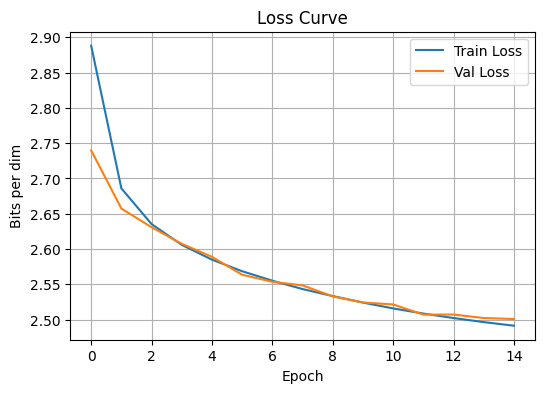

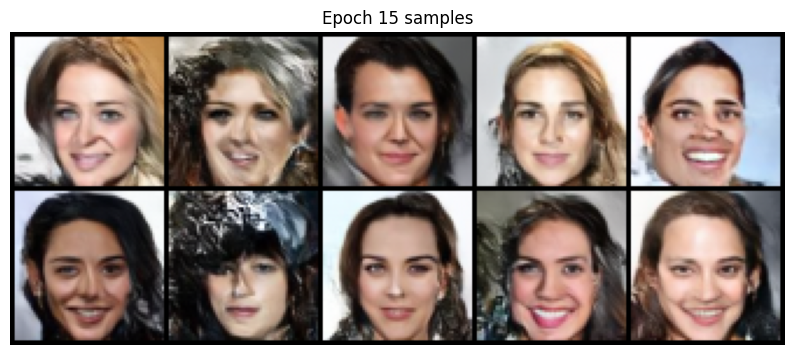

Checkpoint saved: checkpoints_glow/epoch_15.pth


Train:   0%|          | 0/11397 [00:00<?, ?it/s]

In [ ]:
train_and_validate(
    model,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=50,
    device=device,
    grad_clip=3,
    checkpoint_path="checkpoints_glow/epoch_{epoch}.pth"
)

На 16-й эпохе компьютер отключился, пришлось перезапускать позже с 16-й эпохи.

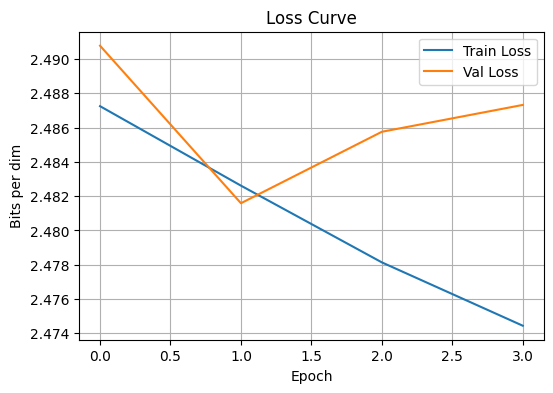

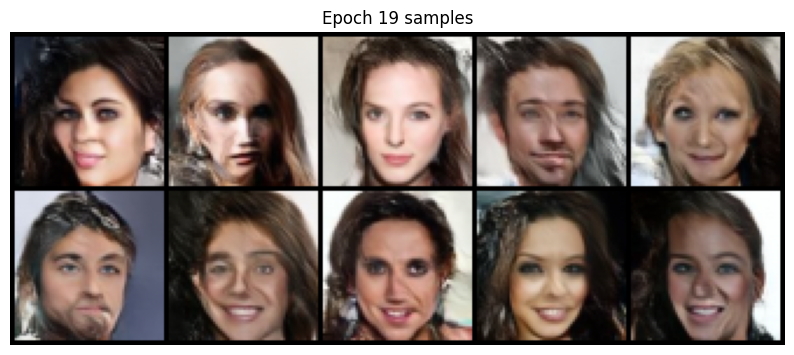

Checkpoint saved: checkpoints_glow/epoch_19.pth


Train:   0%|          | 0/11397 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
train_and_validate(
    model,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=50,
    device=device,
    grad_clip=3,
    checkpoint_path="checkpoints_glow/epoch_{epoch}.pth"
)

На 20-й эпохе понял, что могу не успеть к дедлайну. Сдал с обученной на 19 эпохах. Продолжил обучать с 20-й.

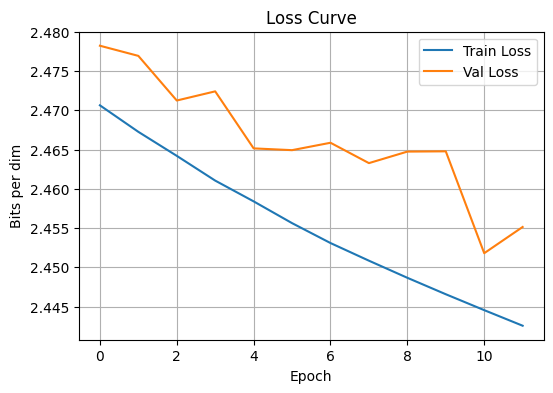

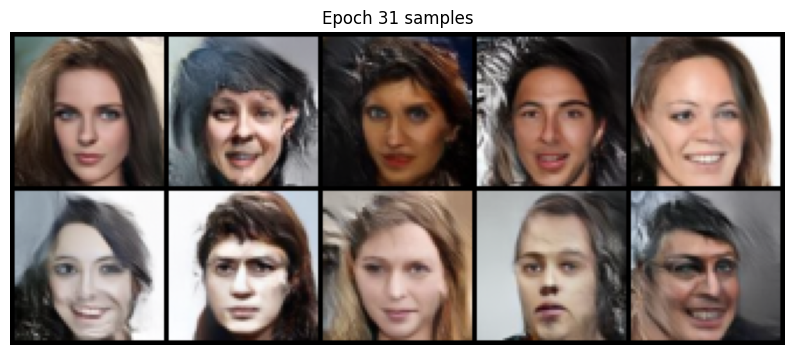

Checkpoint saved: checkpoints_glow/epoch_31.pth


In [95]:
train_and_validate(
    model,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=50,
    device=device,
    grad_clip=3,
    checkpoint_path="checkpoints_glow/epoch_{epoch}.pth"
)

На 31-й эпохе остановилось обучение. Продолжил обучать с 32-й.

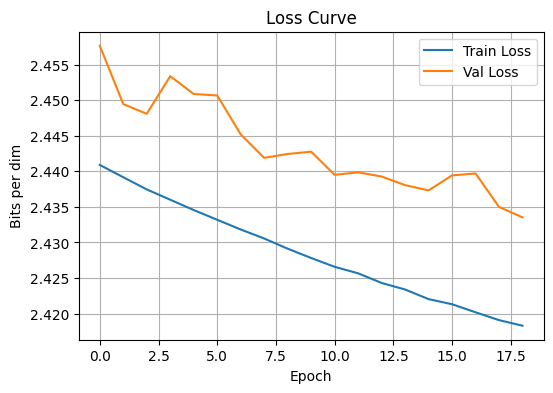

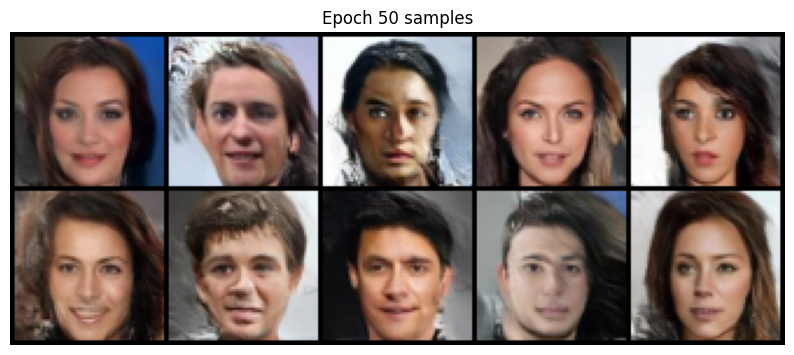

Checkpoint saved: checkpoints_glow/epoch_50.pth


In [98]:
train_and_validate(
    model,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=50,
    device=device,
    grad_clip=3,
    checkpoint_path="checkpoints_glow/epoch_{epoch}.pth"
)

### Задание 12: Sampling Temperature (0.5 балла)

После того как мы обучили модель, мы можем загрузить её, чтобы использовать для генерации. Код ниже загружает веса модели, которые были сохранены во время обучения.

In [94]:
checkpoint_path = "checkpoints_glow/epoch_19.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model loaded from: {checkpoint_path}")

model.to(device)

Model loaded from: checkpoints_glow/epoch_19.pth


Glow(
  (preprocess): Preprocess()
  (blocks): ModuleList(
    (0): MultiScaleBlock(
      (squeeze): Squeeze()
      (flow_steps): ModuleList(
        (0-31): 32 x FlowStep(
          (actnorm): ActNorm()
          (conv): Invertible1x1Conv()
          (coupling): AffineCouplingLayer(
            (net): Sequential(
              (0): Conv2d(6, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU(inplace=True)
              (2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
              (3): ReLU(inplace=True)
              (4): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
      )
      (split_layer): Split(
        (prior): GaussianPrior(
          (net): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): MultiScaleBlock(
      (squeeze): Squeeze()
      (flow_steps): ModuleList(
        (0-31): 32 x FlowStep(
          (actnorm): ActNorm()
       

Теперь начинается самое интересное — исселедовать процесс генерации. Какой параметр, по вашему мнению, отвечает за температуру генерации? Каким образом это происходит?

**Ваш ответ:**
Температура генерации контролируется через дисперсию латентного пространства, у нас z_std в model.inverse - это как раз отклонение (корень из дисперсии). Если дисперсия мала, то распределение больше сконцентрировано около нуля, сэмплы более похожи на тренировочные данные, разнообразие меньше.
Если дисперсия выше, то больше разнообразие латентных переменных, больше разнообразие сгенерированных картинок.

Проверьте вашу гипотезу на практике. Сгенерируйте по $20$ изображений c различными значениями этого параметра и сделайте выводы.

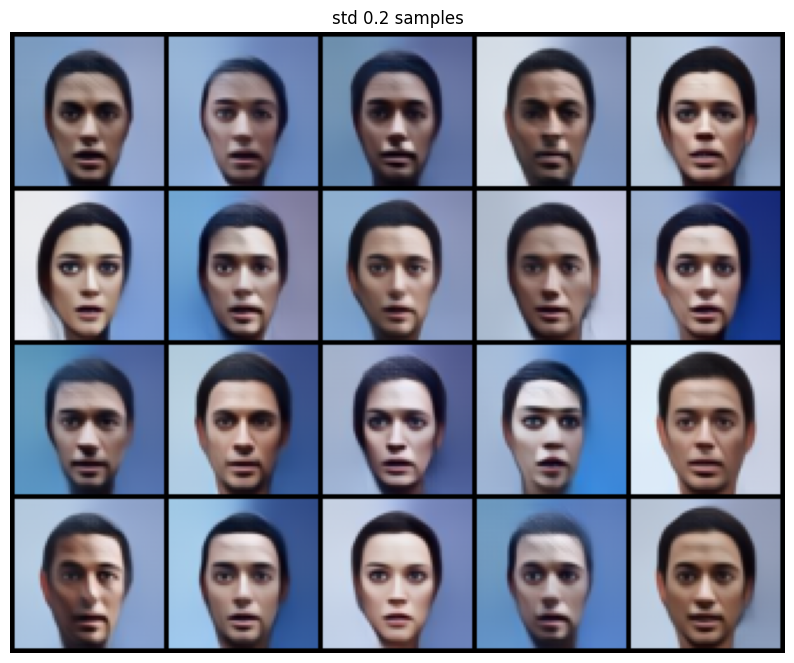

In [99]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Your code here
# Низкая температура
samples = sample(model, n_samples=20, z_std=0.2)
plot_images(samples, nrow=5, title=f"std 0.2 samples")

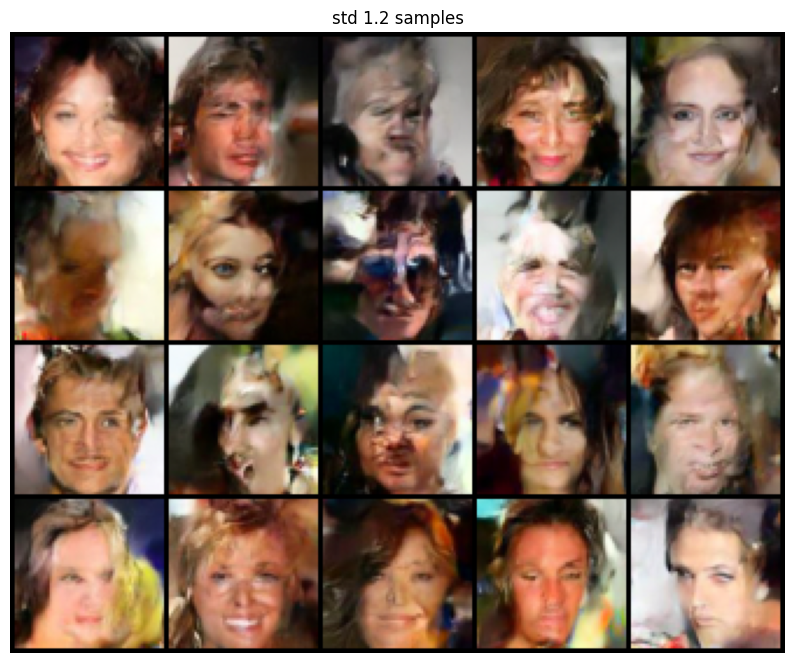

In [100]:
# Высокая температура
samples = sample(model, n_samples=20, z_std=1.2)
plot_images(samples, nrow=5, title=f"std 1.2 samples")

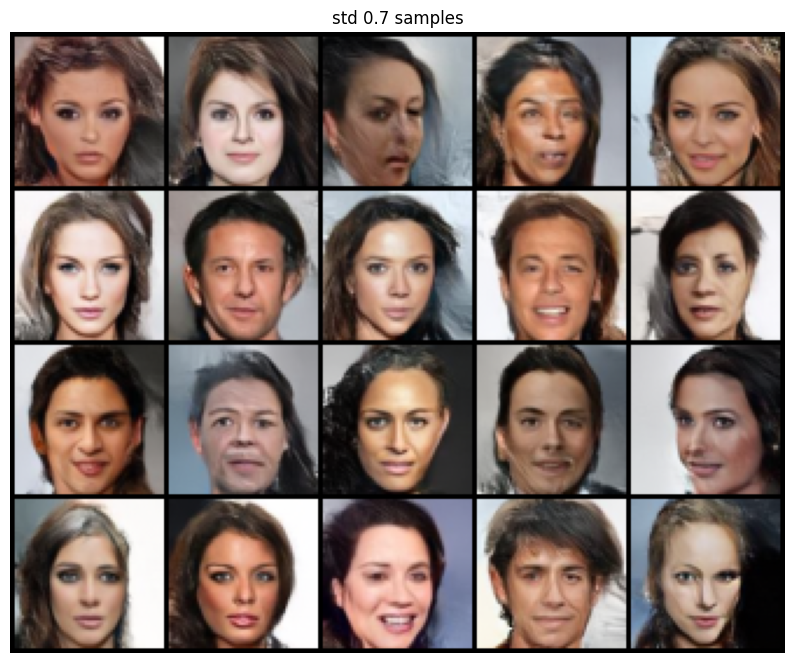

In [101]:
# Средняя температура
samples = sample(model, n_samples=20, z_std=0.7)
plot_images(samples, nrow=5, title=f"std 0.7 samples")

При низкой температуре получаем качественное изображение лица, но лицо на всех картинках приблизительно одинаковое.
При высокой температуре получаем более разнообразные лица, но они обезображены артефактами. Тут ещё накладывается то, что модель мало поучилась (всего 19 эпох).
При средней температуре имеем промежуточный результат: больше разнообразия, чем при низкой температуре, меньше артефактов, чем при высокой температуре.

### Задание 13: Latent Space (0.5 балла)

До сих пор мы рассматривали нашу модель как "черный ящик", который при обратном проходе возвращает изображение. Но самое интересное происходит в его латентном пространстве.

**Латентное пространство** — это многомерное векторное пространство, в котором модель хранит свое понимание данных в некотором структурированном виде.

В плохой, необученной модели это пространство хаотично. Но хорошо обученная модель организует его осмысленно.

**Свойства "хорошего" латентного пространства**:

- **Гладкость**: Точки, которые находятся близко друг к другу в латентном пространстве, должны соответствовать визуально похожим изображениям. Если мы возьмем вектор $\mathbf{z}$ и немного его сдвинем, получив $\mathbf{z}'$, то сгенерированное изображение $\mathbf{x}'$ должно лишь слегка отличаться от исходного $\mathbf{x}$.

- **Семантическая структура**: Модель часто учится выстраивать в пространстве целые направления, соответствующие осмысленным атрибутам. Например, движение вдоль одной оси может делать лицо на картинке более улыбчивым, а движение вдоль другой — изменять цвет волос.

Мы можем проверить, что наша модель действительно выучила такое гладкое и осмысленное пространство с помощью линейной интерполяции:

1. Мы берем два разных изображения, например, мужское лицо ($\mathbf{x}_{man}$) и женское ($\mathbf{x}_{woman}$).

2. Находим их вектора в латентном пространстве: $\mathbf{z}_{man}= f(\mathbf{x}_{man})$ и $\mathbf{z}_{woman}= f(\mathbf{x}_{woman})$

3. Поскольку $\mathbf{z}$ — это просто векторы, мы можем найти любую точку на прямой линии между ними по формуле:

$$\mathbf{z}_{interp} =  (1-\alpha)\cdot \mathbf{x}_{man} + \alpha \cdot \mathbf{x}_{woman}$$

Если пространство действительно гладкое и осмысленное, то, декодируя эти промежуточные точки $\mathbf{z}_{interp}$, мы должны увидеть плавный правдоподобный переход одного изображения в другое.

В этом задании вам предстоит реализовать две новые функции:

- `inverse_reconstruct`: декодер, который принимает на вход конкретный список латентных векторов `zs` и восстанавливает из них изображение.

- `interpolate_glow`: функция для интерполяции, которая будет использовать `inverse_reconstruct` для визуализации плавного перехода между двумя изображениями.

In [31]:
with torch.no_grad():
    model.eval()
    zs, logdet = model.forward(next(iter(val_loader)).to(device))
for z in zs:
    print(z.size())

torch.Size([16, 6, 32, 32])
torch.Size([16, 12, 16, 16])
torch.Size([16, 48, 8, 8])


In [102]:
@torch.no_grad()
def inverse_reconstruct(model, zs: List[torch.Tensor]) -> torch.Tensor:
    """
    Performs the inverse pass from a given list of latent tensors `zs`.
    """

    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    # Your code here
    # По аналогии с inverse в Glow, только z у нас уже есть все, не сэмплим их
    zs_remaining = zs.copy()
    x = zs_remaining.pop()

    for i, block in enumerate(reversed(model.blocks)):
        if block.split:
            z_split = zs_remaining.pop()
            x = block.inverse(x, z_split)
        else:
            x = block.inverse(x, None)
    x = model.preprocess.inverse(x)

    return x

def interpolate_glow(model, image1: torch.Tensor, image2: torch.Tensor, num_steps: int, device: torch.device) -> torch.Tensor:
    """
    Performs latent space interpolation between two images using the Glow model.
    """
    model.eval()
    x1 = image1.unsqueeze(0).to(device)
    x2 = image2.unsqueeze(0).to(device)

    # Encode the two images to get their latent representations using the model's forward pass.
    zs1, _ = model.forward(x1)
    zs2, _ = model.forward(x2)

    # For simplicity, we will only interpolate the last (deepest) z-vector in the list.
    z1_deepest = zs1[-1]
    z2_deepest = zs2[-1]

    # Create a tensor of alpha values for interpolation (from 0.0 to 1.0).
    alphas = torch.linspace(0, 1, steps=num_steps, device=device)

    interpolated_images = []
    for alpha in tqdm(alphas, desc="Generating interpolation"):
        # Calculate the interpolated z-vectors
        z_deep = (1 - alpha) * z1_deepest + alpha * z2_deepest
        zs_interp = zs1[:-1] + [z_deep]
        x_interp = inverse_reconstruct(model, zs_interp)[0]  # [C,H,W]
        interpolated_images.append(x_interp.cpu())
    interpolated_images = torch.stack(interpolated_images, dim=0)
    return interpolated_images

Найдите в валидационном датасете пары изображений, соответствующие описаниям ниже, и, используя реализованные вами функции для каждой пары выполните интерполяцию с `num_steps=10`:

- **Мужчина** $\rightarrow$ **Женщина**
- **Улыбающееся лицо** $\rightarrow$ **Нейтральное лицо**
- **Светлые волосы** $\rightarrow$ **Темные волосы**


In [103]:
def get_image(index: int) -> None:
    img_path = os.path.join(IMAGE_DIR, sorted(os.listdir(IMAGE_DIR))[index])
    original_image = Image.open(img_path)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    image = full_dataset[index]  # [3, 64, 64] в [0, 1]
    image_np = image.permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    plt.title("After transform")
    plt.axis('off')
    plt.show()
    return image

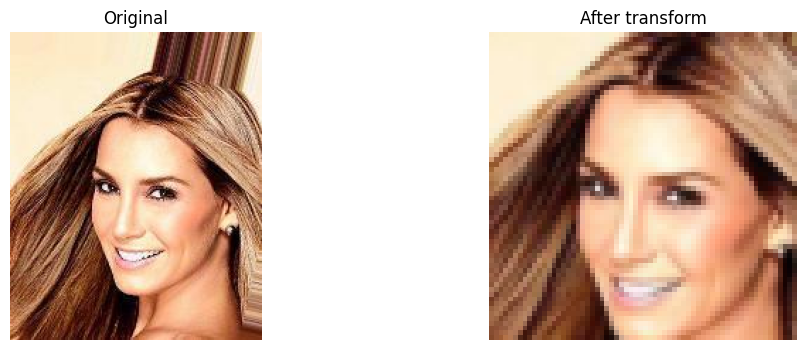

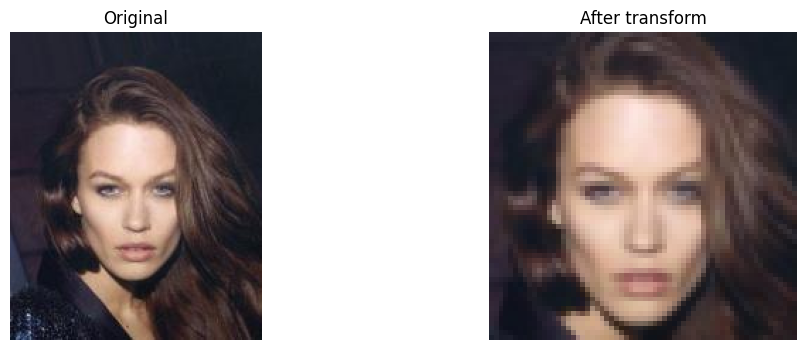

In [104]:
img1 = get_image(0)
img2 = get_image(141)

Generating interpolation:   0%|          | 0/10 [00:00<?, ?it/s]

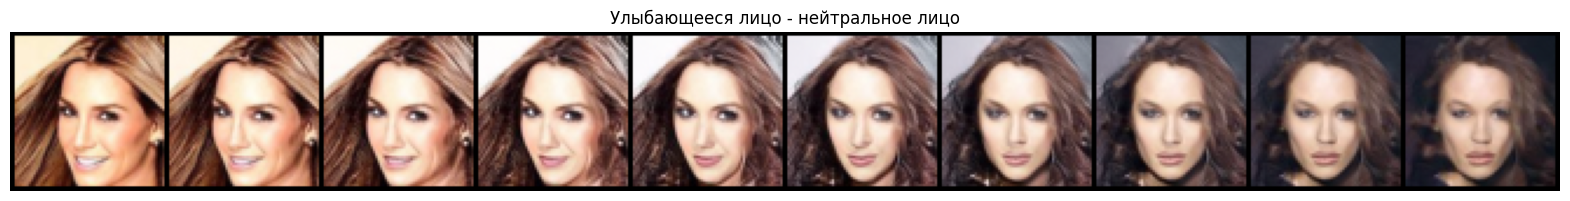

In [105]:
plot_images(interpolate_glow(model, image1=img1, image2=img2, num_steps=10, device=device),
            nrow=10,
            title="Улыбающееся лицо - нейтральное лицо")

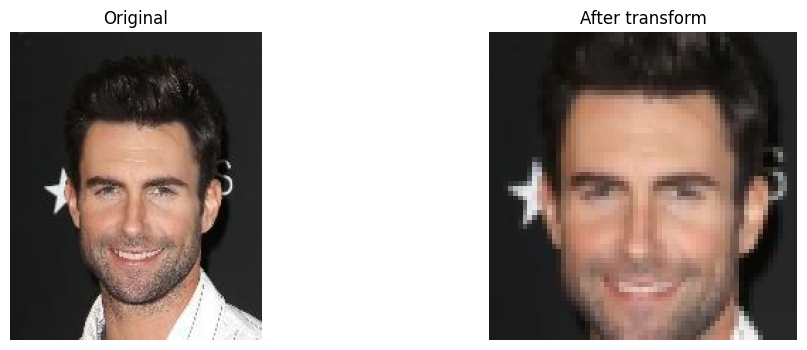

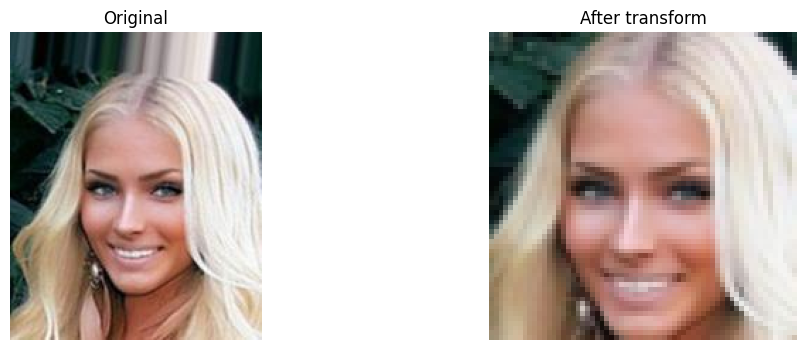

In [107]:
img1 = get_image(128)
img2 = get_image(125)

Generating interpolation:   0%|          | 0/10 [00:00<?, ?it/s]

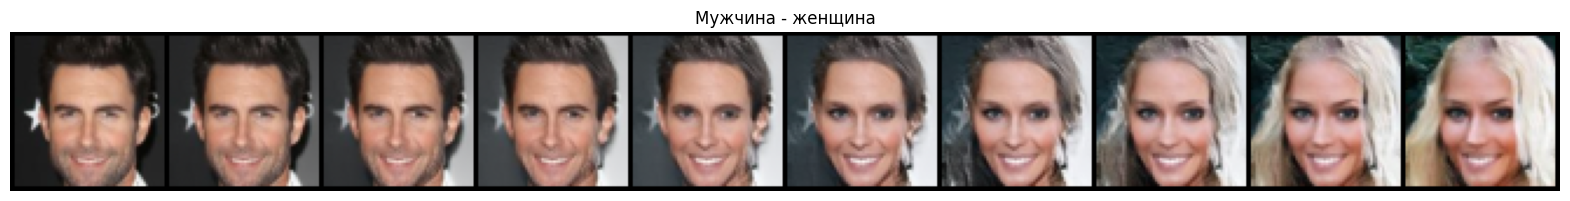

In [108]:
plot_images(interpolate_glow(model, image1=img1, image2=img2, num_steps=10, device=device),
            nrow=10,
            title="Мужчина - женщина")

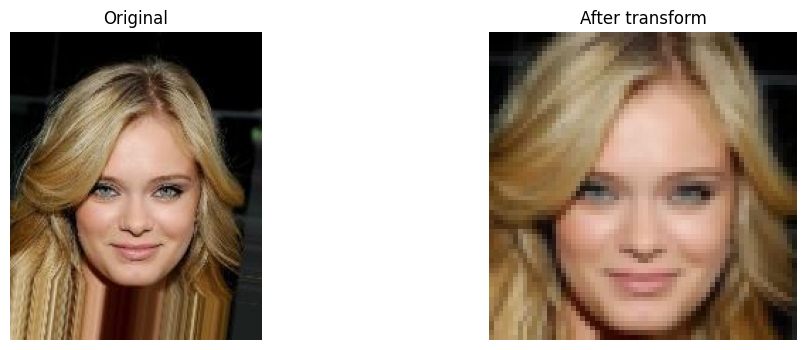

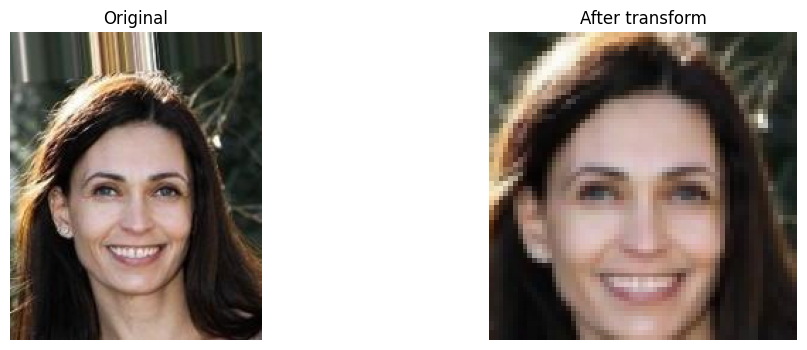

In [110]:
img1 = get_image(79504)
img2 = get_image(79591)

Generating interpolation:   0%|          | 0/10 [00:00<?, ?it/s]

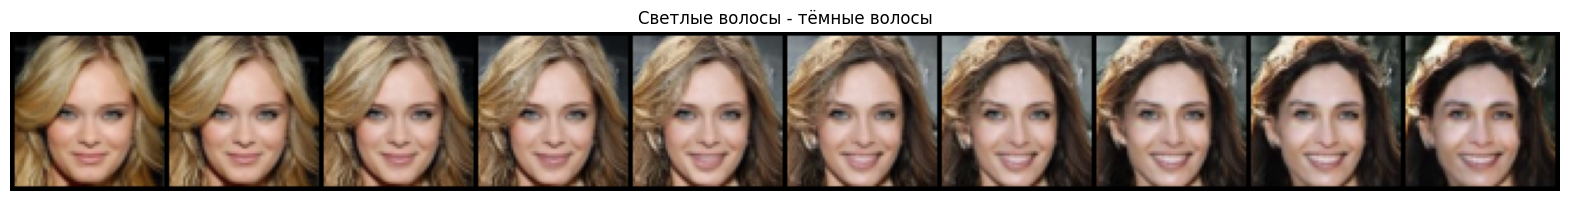

In [111]:
plot_images(interpolate_glow(model, image1=img1, image2=img2, num_steps=10, device=device),
            nrow=10,
            title="Светлые волосы - тёмные волосы")

# Здесь можно оставить отзывы, пожелания и впечатления о ДЗ :)
Фух! Думал уж не успею. Кода много. Дебажить долго (1 эпоха больше часа, а проблема всплывала через несколько эпох). Но зато, во-первых - это красиво. А ведь это только 19 эпох.
Во-вторых, руками прошёл сложную модель, все внутренности изучил. Если коротко, то сложно, очень затратно по времени. Другие дела по учёбе и работе отодвинуты в сторону и запущены местами. Но после этой домашки точно чувствуешь себя чуть более опытным специалистом.